In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#df = pd.read_csv("../input/videogamesales/vgsales.csv")
df = pd.read_csv('../input/clean-datav3/clean_dates.csv') #To not repeat the fixing dates functions
print("Dataset shape : "+str(df.shape))
df.head()

# **Data Pre-processing**

## Dealing with missing data

In [ ]:
df.isna().sum()

### To fix these missing data i'm going to scrap the information from google research using **BeautifulSoup** and **requests**


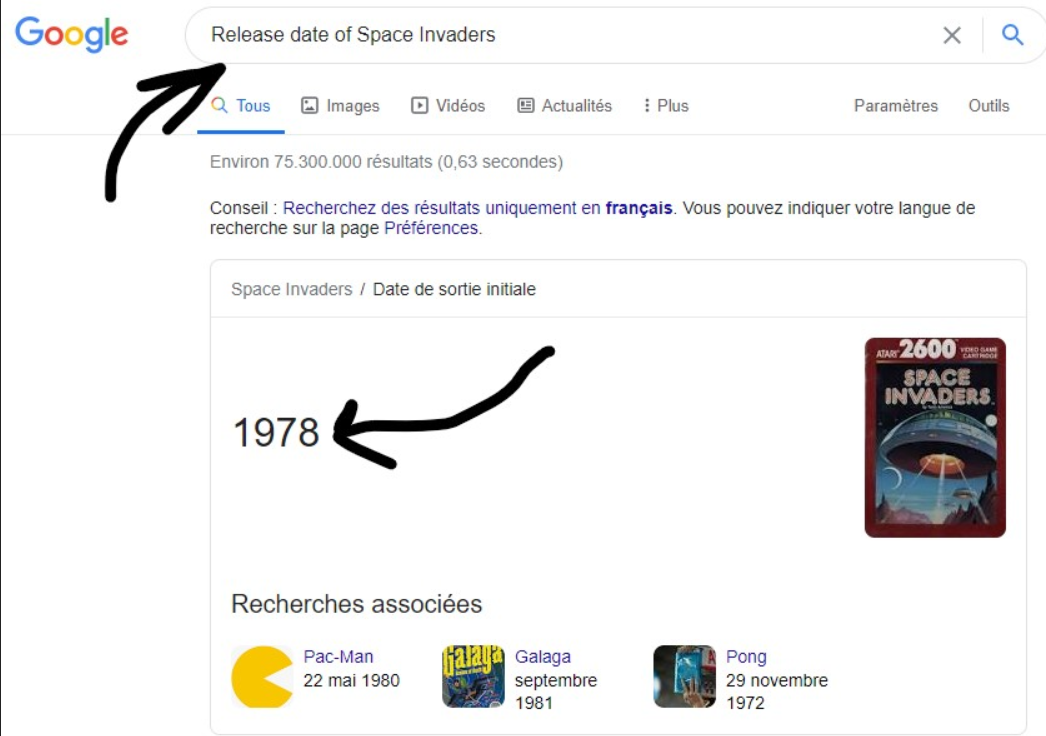

## Preparing Selenium and webbrowser to use in kaggle (you can skip the following commands just for installation )

In [ ]:
!pip install selenium
!apt-get install -y libgtk-3-0 libdbus-glib-1-2 xvfb
!pip install webdriverdownloader

In [ ]:
!cat /etc/os-release
!ls -l .
!echo "ls -l /kaggle"
!ls -l /kaggle

!echo "\nls -l /kaggle/working"
!ls -l /kaggle/working
!ls -l "../input"
!mkdir "../working/firefox"


In [ ]:
!ls -l "../working"
!cp -a "../input/firefox-63.0.3.tar.bz2/firefox/." "../working/firefox"
!ls -l "../working/firefox"
!chmod -R 777 "../working/firefox"
!ls -l "../working/firefox"


In [ ]:
# INSTALL LATEST VERSION OF THE WEB DRIVER
from webdriverdownloader import GeckoDriverDownloader
gdd = GeckoDriverDownloader()
gdd.download_and_install("v0.23.0")

In [ ]:
!apt-get install -y libgtk-3-0 libdbus-glib-1-2 xvfb
!export DISPLAY=:99

### Importing libraries and preparing browser to use with selenium

In [ ]:
from bs4 import BeautifulSoup
import re
import requests
from datetime import datetime
import time
from selenium import webdriver as selenium_webdriver
from selenium.webdriver.firefox.options import Options as selenium_options
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities as selenium_DesiredCapabilities
browser_options = selenium_options()
browser_options.add_argument("--headless")
browser_options.add_argument("--window-size=1920,1080")

capabilities_argument = selenium_DesiredCapabilities().FIREFOX
capabilities_argument["marionette"] = True

browser = selenium_webdriver.Firefox(
    options=browser_options,
    firefox_binary="../working/firefox/firefox",
    capabilities=capabilities_argument
)
browser.set_window_size(1366, 768)

In [ ]:
#Request-html we're not using it to delete later
!pip install requests-html
from requests_html import HTMLSession
from requests_html import AsyncHTMLSession
session = HTMLSession()
r = session.get("https://www.google.com/search?q=Release date of Super Mario Bros.")
s = r.html.find('#main', first=True)

### Our functions to scrap releasing dates

In [ ]:
url = "https://www.google.com/search?q=Release date of "
#url =  "https://en.wikipedia.org/wiki/"
fixed = 0
not_fixed = 0
iteration = 0
start_time = time.time()

In [ ]:
def find_date(game_name,url_ext=""):
    global fixed,not_fixed,iteration
    if ':' in game_name:
        game_name = game_name.split(':')[0]
    answer = False
    print("Looking Released year of : "+game_name + " From the platform :"+url_ext)
    iteration += 1
    current_time = time.time()
    if (iteration % 50 == 0):
        print('*'*80)
        print('Iteration : '+str(iteration)+' Seconds passed : '+ str(current_time-start_time))
        print('We have : '+str(fixed) +' date fixed and '+str(not_fixed)+str(' not fixed'))
        print('*'*80)
    #browser.get(url+str(game_name))  #For known video games
    browser.get(url+str(game_name)+" "+str(url_ext))
    title = browser.title
    for i in range(5): #Here i loop with because some of them are not having same number of divs , even tho still having problems 
        search = browser.find_elements_by_xpath('//*[@id="rso"]/div[1]/div[1]/div[1]/div[1]/div/div['+str(i)+']/div/div[1]/div/div/div[1]')
        if search :
            answer = search[0].text       
            if ',' in answer :
                answer = answer.split(',')[1]   
                #Here we need to split by \ and take the first part , because some of them will be like 2005\nUsa
            if '\n' in answer :    
                answer = answer.split('\n')[0]
            try:
                answer = str(re.search(r'\d+', answer).group())
            except:
                pass
            if len(answer) > 0:
                fixed += 1
                answer = float(answer)
                print("Found year : "+str(answer))
            break
        else :
            continue
    if not answer :
        not_fixed += 1
        print("Not found :(")
        answer = None
    return answer



In [ ]:
df[df['Year'].isna()]

In [ ]:
find_date("Maze Craze: A Game of Cops 'n Robbers",url_ext="2600")

### Using BeautifulSoup (By Omar el Yousfi)

In [ ]:
def find_date2(game_name):
    global fixed,not_fixed,iteration
    #print("Looking Released year of : "+game_name)
    iteration += 1
    current_time = time.time()
    if (iteration % 50 == 0):
        print('*'*80)
        print('Iteration : '+str(iteration)+' Seconds passed : '+ str(current_time-start_time))
        print('We have : '+str(fixed) +' date fixed and '+str(not_fixed)+str(' not fixed'))
        print('*'*80)
    pagex = requests.get("https://en.wikipedia.org/wiki/"+game_name)
    soup = BeautifulSoup(pagex.content, 'html.parser')
    result = soup.find(id='content')
    job_elems = result.find_all('div', class_='plainlist')
    #print(str(job_elems))
    x = re.search(r'\d{4}', str(job_elems))
    if x:
        date = float(datetime.strptime(x.group(), '%Y').date().year)
        #print(date.year)
        fixed += 1
    else :
        date = None
        not_fixed += 1
    return date

### Testing Our fucntion :

In [ ]:
find_date("Wii Sports")

In [ ]:
find_date2("The Chronicles of Narnia: The Lion, The Witch and The Wardrobe")

In [ ]:
# for i in range(200):
#     game_name = df.Name[i]
#     print(game_name)
#     pagex = requests.get("https://en.wikipedia.org/wiki/"+game_name)
#     soup = BeautifulSoup(pagex.content, 'html.parser')
#     result = soup.find(id='content')
#     job_elems = result.find_all('div', class_='plainlist')
#     #print(str(job_elems))
#     x = re.search(r'\d{4}', str(job_elems))
#     print(x)
#     if x:
#         date = float(datetime.strptime(x.group(), '%Y').date().year)
#         print(date)
#         fixed += 1
#     else :
#         date = None
#         not_fixed += 1

### Now we gonna use our function to fill all the na  values in our column "Year" by scrapping the correct value from google.

The two first functions are going to fix 173 missing dates and we're going to save them in clean_data.csv

In [ ]:
# df['Year'] = df.apply(lambda row : find_date(row['Name'],row['Platform']) if np.isnan(row['Year']) else row['Year'],axis=1) #Selenium
# print('By First function :')
# print("Dates fixed : "+str(fixed))
# print("Dates not fixed : "+str(not_fixed))
# iteration =  0
# fixed = 0
# not_fixed = 0
# df['Year'] = df.apply(lambda row : find_date2(row['Name']) if np.isnan(row['Year']) else row['Year'],axis=1) #BSoup
# print('By Second function :')
# print("Dates fixed : "+str(fixed))
# print("Dates not fixed : "+str(not_fixed))
# browser.close() #To close the browser we used to scrap , you can comment this no need

### As you can see still lot of missing dates , its very hard to scrap the values from google because the xpath or class are constatly changing , however we filled 106 missing dates from 271 better than nothing

In [ ]:
df.isna().sum()

Saving the data so we wont execute the function everytime.

In [ ]:
df.to_csv('clean_dates.csv',index=False) #U need to download it then upload it into inputs since we have right read-only in cmds

### The dataset was using Float form in date , i decided to make them int better ( U can leave them float not a big deal)

In [ ]:
df['Year'] = df['Year'].fillna(0.0) #To delete later when u fix the last missing dates , just so we can visualize

In [ ]:
df['Year'] = df['Year'].astype(int)
df['Global_Sales'] = df['Global_Sales'].astype(int)
df['NA_Sales'] = df['NA_Sales'].astype(int)
df['Year'] = df['Year'].apply(pd.to_numeric, errors='ignore')
df.info()


# **Data Visualization**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

### Let's Try to visualize the number of sales in each country , then adding the platform , publisher , genre in our visualization

In [ ]:
NA_SALES = df['NA_Sales'].sum()
EU_SALES = df['EU_Sales'].sum()
JP_SALES = df['JP_Sales'].sum()
OTHER_SALES = df['Other_Sales'].sum()
X = ['North America','Europe','Japan','Other']
Y = [NA_SALES,EU_SALES,JP_SALES,OTHER_SALES ]
plt.bar(X,Y,color=('orange','purple','darkolivegreen','pink'))
plt.xlabel("Countries")
plt.ylabel("Price in (in millions)")

### That doesn't mean that games are sold more in NA , but NA made most millions by selling video games than other countries

In [ ]:
df.head()

In [ ]:
sales_genre_platform = df[['Global_Sales','Genre','Platform']]
grouped = sales_genre_platform.groupby('Genre').agg({'Global_Sales':'sum','Platform':lambda x:x.value_counts().index[0]})
grouped.reset_index(inplace=True)
grouped.head()

### Here , we're aggregating the column Global_sales by sum so we can have the sum of sales for each genre , and the most frequent platform sold for this same game

In [ ]:
plt.figure(figsize=(1520,800))
plot = sns.relplot(x="Genre", y="Global_Sales", hue="Platform", data=grouped,height=8.27, aspect=11.7/8.27,s=90);
plt.title("Games Sold by Genre and Platform")
plot.set(xlabel="Genre of games",ylabel='Sales in Millions')

##### As we can see the most sold games are action video games on PS3 (This is gotta be an old data )

What we can conclude from that is that most of people who plays video games on pc are not buying the game ( Using cracks ) , However on ps3 even that there is cracks but the facts that you can play online anymore after cracking a game was pushing people to buy the games .
And also Buying a playstation3 was cheaper than buying a pc that can turns ps3 games

In [ ]:
sales_platform = df[['Global_Sales','Platform']]
grouped2 = sales_platform.groupby('Platform').sum().sort_values(by='Global_Sales',ascending=False)
grouped2.reset_index(inplace=True)
plt.figure(figsize=(20,7))
grouped2 = grouped2.head()
plt.bar(grouped2.Platform,grouped2.Global_Sales,color=('orange','purple','darkolivegreen','pink','darkblue'))
plt.xlabel('Platforms')
plt.ylabel('Sales in millions $')
grouped2.head()

### The next analysis we'll try to use the release date to analyse some features

*We gonna consider that the sales are made the same year as realizing date*

In [ ]:
year_plat_sales = df[['Year','Platform','Global_Sales']]
year_plat_sales = year_plat_sales[year_plat_sales['Year'] != 0] #Drop uknow year rows
year_plat_sales.loc[(year_plat_sales.Platform == '2600'),'Platform']='Atari 2600'#2600 means the Atari 2600 so better make it clear

#grouped3 = year_plat_sales.groupby(['Year','Platform'])[['Global_Sales']].sum() #To remember used to grouped by and exlude some columns but not usefull here
grouped3 = year_plat_sales.groupby('Year').agg({'Global_Sales':'sum','Platform':lambda x:x.value_counts().index[0]})
#As we did before for the platform we're using only more frequent not the best solution but we want to analyse the different sales in each platform we'll need to treat each year separatly so we can read the graph
grouped3.reset_index(inplace=True)
plt.figure(figsize=(20,7))

plot = sns.lineplot(x="Year", y="Global_Sales",
             hue="Platform", 
             data=grouped3)
grouped3['Platform'].unique()

### Now let's see the different sales in countries by years

In [ ]:
year_country_sales = df[['Year','NA_Sales','EU_Sales','JP_Sales','Other_Sales']]
year_country_sales = year_country_sales[year_country_sales['Year'] != 0] #Drop uknow year rows
grouped4 = year_country_sales.groupby('Year').sum() #Group By year
grouped4.reset_index(inplace=True)
plt.figure(figsize=(20,7))
grouped4 = grouped4.rename(columns={'NA_Sales': 'Sales1', 'EU_Sales': 'Sales2','JP_Sales':'Sales3','Other_Sales':'Sales4'})
#Here i rename the columns so i change change the format of the data
grouped4 = pd.wide_to_long(grouped4,stubnames='Sales',i='Year',j='Country') #Long format is usefull here to plot our graph 
grouped4.reset_index(inplace=True)
grouped4['Country'] = grouped4['Country'].replace([1,2,3,4], ['NA','EU','JP','Other']) #Because i had to make them numbers to use the function wide_to_long
plot = sns.lineplot(x="Year", y="Sales",
             hue="Country", 
             data=grouped4)

## The sales are falling down in 2018+ because we don't have these news data , to fix that let's predict the prices in 2020 based on old data untill 2016 (Not done yet )

# **Model Creation**

In [ ]:
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import KFold

### Preparing Our data for applying a machine learning algorithm

In [ ]:
model_df = df.copy()
model_df = model_df[model_df['Year'] <= 2016] #Since we dont have enough data from 2017+
model_df.drop('Name',axis=1,inplace=True)

### We'll need to vectorize the caregorical data

In [ ]:
feature = ["Platform", "Genre"]
le = LabelEncoder()

for col in feature:
    model_df[col] = le.fit_transform(model_df[col])

#cat_data = pd.DataFrame(cat_data).transpose()
#cat_data = cat_data.apply(lambda x:x.fillna(x.value_counts().index[0])) #Fill these 58 missing Publisher by most frequent
#Here we can do it in a better way is that for each missing publisher we gonna take the platform and filter all others data that have same platform 
#then take the most frequent publisher in these data , its gonna be more accurate
model_df.head()

### Let's Encode our categorical Data

In [ ]:
X = model_df[['Year','Genre','Platform', 'Global_Sales']].values
#X = model_df[['Year','Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].values
Y = model_df['NA_Sales'].values #We can change the prediction from here if we want
#Maybe we can try to predict the rank also
X

### Using Cross-Validation to improve the accuracy

In [ ]:
x_train,x_valid,y_train,y_valid = train_test_split(X,Y,test_size=0.2)

#### We'll be using 2 models

In [ ]:
xgb = XGBRegressor(random_state = 5, n_estimators = 1500, learning_rate=0.03)
xgb.fit(x_train,y_train)
r2_score(y_valid, xgb.predict(x_valid))

In [ ]:
lr = LinearRegression()
lr.fit(x_train,y_train)
predictions = lr.predict(x_valid)

print(lr.score(x_valid, y_valid))
r2_score(y_valid,predictions)

#### Using Kfold Cross_Validation (no big changes )

In [ ]:
lr_kfold = LinearRegression()
kfold = model_selection.KFold(n_splits=10, random_state=100)
results_kfold = model_selection.cross_val_score(lr_kfold, x_train, y_train, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

In [ ]:
test=  ['Action','PS2']
test = le.fit_transform(test)
test = np.insert(test,0,2006)
test = np.append(test,65)
test = np.array([test])

lr.predict(test)[0]